## Using astroplan

* [example](https://astroplan.readthedocs.io/en/latest/tutorials/periodic.html)

In [25]:
import sys
import datetime as dt
import numpy as np
import matplotlib.pyplot as pl

from astroquery.exoplanet_orbit_database import ExoplanetOrbitDatabase
from astroplan import FixedTarget, Observer, EclipsingSystem
from astroplan.plots import plot_airmass
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
# from astroplan import download_IERS_A
# download_IERS_A()
from astroplan import (PrimaryEclipseConstraint, MoonSeparationConstraint,
                       is_event_observable, is_always_observable, months_observable,
                       AtNightConstraint, AltitudeConstraint, LocalTimeConstraint,
                       AirmassConstraint)

#lat,lon, elev, timezone
#to see all timezones: import pytz; print(pytz.all_timezones)
sites = {'OAO': (34.5761, 133.5941, 343, "Asia/Tokyo"),
         'TCS': (28.291, 343.5033, 2395, "UTC"), 
         'SBO': (-31.2733, 149.0617, 1145, "Australia/Queensland"), #siding spring observatory
         'TRO': (-30.1692, -70.805, 2286, "America/Santiago") #cerro tololo observatory
         #'SBO': (-17.8799, 28.758, 0, "Australia"), 
         #'TRO': (-28.1911, 153.2654, 0, "UTC")
        }

## EPIC or TOI

In [3]:
import k2plr
client = k2plr.API()

def get_ra_dec(epicnum,verbose=False):
    '''
    get ra, dec, and mag using `k2plr`
    '''
    if verbose:
        print('\nquerying RA and DEC...\n')
    epic = client.k2_star(int(epicnum))
    ra  = float(epic.k2_ra)
    dec = float(epic.k2_dec)
    #mag = float(epic.kp)
    return ra, dec

In [ ]:
targetname = 'TOI460' #None
target_RA  = 47.643478
target_Dec = -9.27681

epoch   = 2458411.065871 #jd
period  = 0.52     #day
duration= 0.9333   #day

In [49]:
n_transits = 1000
include_partial_transits = True

#observation parameters
obs_start_date = '2019-02-17' #UT
obs_start_time = '00:01'      #UT
obs_end_date   = '2019-04-20' #UT
obs_end_time   = '23:59'      #UT
obs_start = ' '.join((obs_start_date, obs_start_time))
obs_end   = ' '.join((obs_end_date, obs_end_time))
observing_time = Time(obs_start)
sitename   = 'TRO'
timezone   = 'America/Santiago'

#constraints
min_local_time = dt.time(19, 0)  # 18:00 local time 
max_local_time = dt.time(0, 0)   # 00:00 local time (midnight)
target_altitude_limit = 30 #deg
min_moon_sep = 10 #deg

#set-up target
#target_RA, target_Dec = get_ra_dec(targetname)

#set-up transit parameters
primary_eclipse_time = Time(epoch, format='jd')
orbital_period = period * u.day  
transit_duration = duration * u.day

if np.all([target_RA, target_Dec]):
    target_coord = SkyCoord(ra=target_RA*u.deg, dec=target_Dec*u.deg)
    targetloc = FixedTarget(target_coord, targetname)
else:
    targetloc = FixedTarget.from_name(targetname)
    
#set-up observation parameters
if sitename in list(sites.keys()):
    lat,lon,elev,timezone = sites[sitename]
    observatory_site = Observer(latitude=lat*u.deg, longitude=lon*u.deg,
                  elevation=elev*u.m, name=sitename, timezone=timezone)
else: 
    observatory_site = Observer.at_site(sitename, timezone=timezone)

ephemeris = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                            orbital_period=orbital_period, 
                            duration=transit_duration,
                            name=targetname+' b')

#see https://astroplan.readthedocs.io/en/latest/tutorials/constraints.html
constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=target_altitude_limit*u.deg),
               LocalTimeConstraint(min=min_local_time, max=max_local_time),
               MoonSeparationConstraint(min=min_moon_sep*u.deg)]

### Note: eclipse times are computed without any barycentric corrections

if include_partial_transits:
    midtransit_times = ephemeris.next_primary_eclipse_time(observing_time, 
                                                           n_eclipses=n_transits)
    idx = is_event_observable(constraints, 
                          observatory_site, 
                          targetloc, 
                          times=midtransit_times)[0]
    if np.any(idx):
        time=midtransit_times[idx][0]
        if time > Time(obs_end):
            print('{}: Next observable event from {} is on {}'
                  .format(targetname, sitename, time))
        else:
            print('{}: Observable partial transits from {} between {} & {}\n{}'
                  .format(targetname, sitename, obs_start, obs_end, midtransit_times[idx]))
    else:
        print('{}: No observable partial transit from {} between {} & {}'
              .format(targetname, sitename, obs_start, obs_end))
else:
    ing_egr_times = ephemeris.next_primary_ingress_egress_time(observing_time, 
                                                               n_eclipses=n_transits)
    idx = is_event_observable(constraints, 
                          observatory_site, 
                          targetloc,  
                          times_ingress_egress=ing_egr_times)[0]
    if np.any(idx):
        time=ing_egr_times[idx][0]
        if time > Time(obs_end):
            print('{}: Next observable event from {} is on {}'
                  .format(targetname, sitename, time))
        else:
            print('{}: Observable full transits from {} between {} & {}\n{}'
                  .format(targetname, sitename, obs_start, obs_end, ing_egr_times[idx]))
    else:
        print('{}: No observable full transit from {} between {} & {}'
              .format(targetname, sitename, obs_start, obs_end))
        
#     plot_airmass(targetloc, 
#                  observatory_site, 
#                  time, 
#                  brightness_shading=True, 
#                  altitude_yaxis=True)
    #ephemeris.next_secondary_eclipse_time(observing_time)
    
#     plot_airmass(targetloc, 
#                  observatory_site, 
#                  time, 
#                  brightness_shading=True, 
#                  altitude_yaxis=True)

TOI460: Next observable event from TRO is on 2020-04-01 23:10:51.254


In [42]:
midtransit_times[0].iso

'2019-02-17 04:56:27.254'

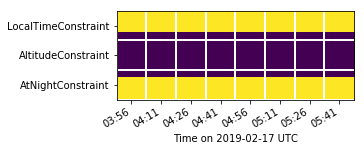

In [48]:
from astroplan.utils import time_grid_from_range
time_resolution = 15 * u.minute

start_time = Time('2019-02-17 03:56:27.254')
end_time   = Time('2019-02-17 05:56:27.254')
# Create grid of times from ``start_time`` to ``end_time``
# with resolution ``time_resolution``
time_grid = time_grid_from_range([start_time, end_time],
                                 time_resolution=time_resolution)

observability_grid = np.zeros((len(constraints), len(time_grid)))

for i, constraint in enumerate(constraints):
    # Evaluate each constraint
    observability_grid[i, :] = constraint(observatory_site, targetloc, times=time_grid)

# Create plot showing observability of the target:

extent = [-0.5, -0.5+len(time_grid), -0.5, 2.5]

fig, ax = pl.subplots()
ax.imshow(observability_grid, extent=extent)

ax.set_yticks(range(0, 3))
ax.set_yticklabels([c.__class__.__name__ for c in constraints])

ax.set_xticks(range(len(time_grid)))
ax.set_xticklabels([t.datetime.strftime("%H:%M") for t in time_grid])

ax.set_xticks(np.arange(extent[0], extent[1]), minor=True)
ax.set_yticks(np.arange(extent[2], extent[3]), minor=True)

ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
ax.tick_params(axis='x', which='minor', bottom='off')
pl.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.tick_params(axis='y', which='minor', left='off')
ax.set_xlabel('Time on {0} UTC'.format(time_grid[0].datetime.date()))
fig.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.1)
pl.show()

## Given a list of targets

## Known target

In [8]:
targetname = 'HD 209458' #None
target_RA  = None
target_Dec = None

n_transits = 10
include_partial_transits = True

epoch = None#2452826.628514 #jd
period= None#3.52474859     #day
duration= None#0.1277       #day

#observation parameters
obs_start_date = '2019-02-19' #UT
obs_start_time = '00:00'      #UT
obs_start = ' '.join((obs_start_date, obs_start_time))
observing_time = Time(obs_start)
sitename   = 'OAO'#'APO'
timezone   = 'US/Mountain'

#constraints
min_local_time = dt.time(19, 0)  # 18:00 local time 
max_local_time = dt.time(0, 0)   # 00:00 local time (midnight)
target_altitude_limit = 30 #deg

#set-up target
if not np.any([epoch,period,duration]):
    try:
        #query database
        planet_properties = ExoplanetOrbitDatabase.query_planet(targetname+' b')
        primary_eclipse_time = Time(planet_properties['TT'], format='jd')
        orbital_period = planet_properties['PER']
        transit_duration = planet_properties['T14']
        print('Mid-transit time reference: {0}; period reference: {1}'
              .format(planet_properties['TTREF'], planet_properties['PERREF']))
    except Exception as e:
        print(e)
        sys.exit()
else:    
    #set-up transit parameters
    primary_eclipse_time = Time(epoch, format='jd')
    orbital_period = period * u.day  
    transit_duration = duration * u.day

if np.all([target_RA, target_Dec]):
    target_coord = SkyCoord(ra=target_RA*u.deg, dec=target_Dec*u.deg)
    targetloc = FixedTarget(target_coord, targetname)
else:
    targetloc = FixedTarget.from_name(targetname)
    
#set-up observation parameters
if sitename in list(sites.keys()):
    lat,lon,elev,timezone = sites[sitename]
    observatory_site = Observer(latitude=lat*u.deg, longitude=lon*u.deg,
                  elevation=elev*u.m, name=sitename, timezone=timezone)
else: 
    observatory_site = Observer.at_site(sitename, timezone=timezone)

ephemeris = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                            orbital_period=orbital_period, 
                            duration=transit_duration,
                            name=targetname+' b')

### Note: eclipse times are computed without any barycentric corrections

midtransit_times = ephemeris.next_primary_eclipse_time(observing_time, n_eclipses=n_transits)
ing_egr_times = ephemeris.next_primary_ingress_egress_time(observing_time, n_eclipses=n_transits)
#ephemeris.next_secondary_eclipse_time(observing_time)

if include_partial_transits:
    ing_egr_times = None
else:
    midtransit_times = None

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=target_altitude_limit*u.deg),
               LocalTimeConstraint(min=min_local_time, max=max_local_time)]

is_event_observable(constraints, observatory_site, targetloc, times=midtransit_times, times_ingress_egress=ing_egr_times)

Mid-transit time reference: Knutson 2007; period reference: Knutson 2007


## K2-target

Mid-transit time reference: Howell 2012; period reference: Howell 2012
2019-03-26 20:26:13.944


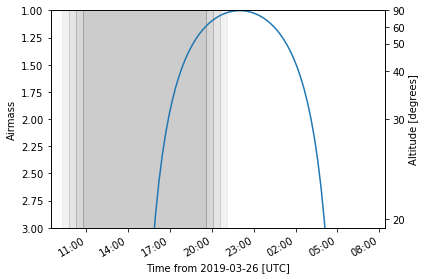

In [42]:
targetname = 'Kepler-21' #None
target_RA  = None
target_Dec = None

n_transits = 100
include_partial_transits = True

epoch = None#2452826.628514 #jd
period= None#3.52474859     #day
duration= None#0.1277       #day

#observation parameters
obs_start_date = '2019-02-19' #UT
obs_start_time = '00:00'      #UT
obs_start = ' '.join((obs_start_date, obs_start_time))
observing_time = Time(obs_start)
sitename   = 'OAO'
timezone   = 'US/Mountain'

#constraints
min_local_time = dt.time(19, 0)  # 18:00 local time 
max_local_time = dt.time(0, 0)   # 00:00 local time (midnight)
target_altitude_limit = 30 #deg

#set-up target
if not np.any([epoch,period,duration]):
    try:
        #query database
        planet_properties = ExoplanetOrbitDatabase.query_planet(targetname+' b')
        
        if isinstance(planet_properties['TT'],np.ma.core.MaskedConstant):
            print('epoch not available in database!')
            sys.exit()
        else:
            primary_eclipse_time = Time(planet_properties['TT'], format='jd')
            
        if isinstance(planet_properties['PER'],np.ma.core.MaskedConstant):
            print('orbital period not available in database!') 
            sys.exit()
        else:
            orbital_period = planet_properties['PER']
        
        if isinstance(planet_properties['T14'],np.ma.core.MaskedConstant):
            print('transit duration not available in database!') 
            sys.exit()
        else:
            transit_duration = planet_properties['T14']
        print('Mid-transit time reference: {0}; period reference: {1}'
              .format(planet_properties['TTREF'], planet_properties['PERREF']))
    except Exception as e:
        print(e)
        sys.exit()
else:    
    #set-up transit parameters
    primary_eclipse_time = Time(epoch, format='jd')
    orbital_period = period * u.day  
    transit_duration = duration * u.day

if np.all([target_RA, target_Dec]):
    target_coord = SkyCoord(ra=target_RA*u.deg, dec=target_Dec*u.deg)
    targetloc = FixedTarget(target_coord, targetname)
else:
    targetloc = FixedTarget.from_name(targetname)
    
#set-up observation parameters
if sitename in list(sites.keys()):
    lat,lon,elev,timezone = sites[sitename]
    observatory_site = Observer(latitude=lat*u.deg, longitude=lon*u.deg,
                  elevation=elev*u.m, name=sitename, timezone=timezone)
else: 
    observatory_site = Observer.at_site(sitename, timezone=timezone)

ephemeris = EclipsingSystem(primary_eclipse_time=primary_eclipse_time,
                            orbital_period=orbital_period, 
                            duration=transit_duration,
                            name=targetname+' b')

constraints = [AtNightConstraint.twilight_civil(),
               AltitudeConstraint(min=target_altitude_limit*u.deg),
               LocalTimeConstraint(min=min_local_time, max=max_local_time)]

### Note: eclipse times are computed without any barycentric corrections

if include_partial_transits:
    midtransit_times = ephemeris.next_primary_eclipse_time(observing_time, 
                                                           n_eclipses=n_transits)
    idx = is_event_observable(constraints, 
                          observatory_site, 
                          targetloc, 
                          times=midtransit_times)[0]
    time = midtransit_times[idx][0]
    print(time)
    plot_airmass(targetloc, 
                 observatory_site, 
                 time, 
                 brightness_shading=True, 
                 altitude_yaxis=True)
    #ephemeris.next_secondary_eclipse_time(observing_time)
else:
    ing_egr_times = ephemeris.next_primary_ingress_egress_time(observing_time, 
                                                               n_eclipses=n_transits)
    idx = is_event_observable(constraints, 
                          observatory_site, 
                          targetloc,  
                          times_ingress_egress=ing_egr_times)[0]
    time=ing_egr_times[idx][0]
    print(time)
    plot_airmass(targetloc, 
                 observatory_site, 
                 time, 
                 brightness_shading=True, 
                 altitude_yaxis=True)

## star plots

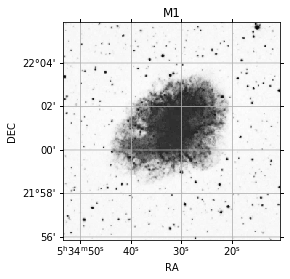

In [20]:
from astroplan.plots import plot_finder_image
from astroplan import FixedTarget
import matplotlib.pyplot as pl

targetloc = FixedTarget.from_name("M1")
ax, hdu = plot_finder_image(targetloc)
pl.show()

In [19]:
import matplotlib.pyplot as pl
from astropy.time import Time
from astroplan.plots import plot_airmass


plot_airmass(target, observer, observing_time)
pl.show()

NameError: name 'observer' is not defined

## Using astroquery.nasa_exoplanet_archive

In [16]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
tab = NasaExoplanetArchive.get_confirmed_planets_table()
#conversion to pandas doesn't work because of mix-in columns (parameter name and units)
#df = tab.to_pandas()
tab[:2]

pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_ttvflag,pl_kepflag,pl_k2flag,ra_str,dec_str,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE,sky_coord
,,,,,,d,d,d,d,,AU,AU,AU,AU,,,,,,,deg,deg,deg,deg,,jupiterMass,jupiterMass,jupiterMass,jupiterMass,,,jupiterRad,jupiterRad,jupiterRad,jupiterRad,,,,,,,,,,,,deg,,deg,,,pc,pc,pc,pc,,mag,mag,mag,,,,,K,K,K,K,,solMass,solMass,solMass,solMass,,solRad,solRad,solRad,solRad,,,,,,"deg,deg"
str27,str1,str29,str29,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str14,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,str14,str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str11,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str10,str44,str26,object
Kepler-54,c,Kepler-54 c,Transit,0,3,12.0717249,0.00029,-0.00029,0.0,5,0.0,0.0,0.0,0.0,0,--,--,--,--,0,0.0,0.0,0.0,0.0,0,0.37,0.0,0.0,1.0,2,Mass,0.11,0.0,0.0,0.0,6,--,--,--,--,0,1,1,0,19h39m05.75s,+43d03m22.7s,294.773939,1.7e-05,43.056295,1.7e-05,2,234.0,17.91,-17.24,0.0,3,15.847,0.0,0.0,Kepler-band,15.813,--,0,4252.0,100.0,-100.0,0.0,10,0.0,0.0,0.0,0.0,7,0.55,0.02,-0.02,0.0,11,1,2014-05-14,Kepler,kepler-54c,"294.773939,43.056295"
Kepler-54,d,Kepler-54 d,Transit,0,3,20.995694,0.000143,-0.000143,0.0,4,0.126,0.0,0.0,0.0,1,--,--,--,--,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,--,0.136,0.007,-0.007,0.0,5,--,--,--,--,0,1,1,0,19h39m05.75s,+43d03m22.7s,294.773939,1.7e-05,43.056295,1.7e-05,2,234.0,17.91,-17.24,0.0,3,15.847,0.0,0.0,Kepler-band,15.813,--,0,4252.0,100.0,-100.0,0.0,10,0.0,0.0,0.0,0.0,7,0.55,0.02,-0.02,0.0,11,1,2014-05-14,Kepler,kepler-54d,"294.773939,43.056295"


In [38]:
q = NasaExoplanetArchive.query_planet('WASP-107b')
q

pl_hostname,pl_letter,pl_name,pl_discmethod,pl_controvflag,pl_pnum,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbpern,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxn,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenn,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbincln,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassn,pl_bmassprov,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radn,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densn,pl_ttvflag,pl_kepflag,pl_k2flag,ra_str,dec_str,ra,st_raerr,dec,st_decerr,st_posn,st_dist,st_disterr1,st_disterr2,st_distlim,st_distn,st_optmag,st_optmagerr,st_optmaglim,st_optband,gaia_gmag,gaia_gmagerr,gaia_gmaglim,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffn,st_mass,st_masserr1,st_masserr2,st_masslim,st_massn,st_rad,st_raderr1,st_raderr2,st_radlim,st_radn,pl_nnotes,rowupdate,pl_facility,NAME_LOWERCASE,sky_coord
,,,,,,d,d,d,d,,AU,AU,AU,AU,,,,,,,deg,deg,deg,deg,,jupiterMass,jupiterMass,jupiterMass,jupiterMass,,,jupiterRad,jupiterRad,jupiterRad,jupiterRad,,,,,,,,,,,,deg,,deg,,,pc,pc,pc,pc,,mag,mag,mag,,,,,K,K,K,K,,solMass,solMass,solMass,solMass,,solRad,solRad,solRad,solRad,,,,,,"deg,deg"
str27,str1,str29,str29,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,str14,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,int64,int64,str14,str15,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,str11,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,str10,str44,str26,object
WASP-107,b,WASP-107 b,Transit,0,1,5.72149,2e-06,-2e-06,0.0,3,0.055,0.001,-0.001,0.0,3,0.0,--,--,0,3,89.7,0.2,-0.2,0.0,3,0.12,0.01,-0.01,0.0,3,Mass,0.94,0.02,-0.02,0.0,3,0.19,0.03,-0.03,0,2,0,0,0,12h33m32.85s,-10d08m46.1s,188.386871,0.0,-10.146149,0.0,1,64.86,0.26,-0.26,0.0,1,11.471,0.196,0.0,V (Johnson),11.174,--,0,4430.0,120.0,-120.0,0.0,3,0.69,0.05,-0.05,0.0,3,0.66,0.02,-0.02,0.0,4,0,2017-08-17,SuperWASP-South,wasp-107b,"188.386871,-10.146149"


In [54]:
per = q['pl_orbper'].value
per